In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Step 2: Import required libraries
import zipfile
import os

Mounted at /content/drive


In [ ]:
# Step 3: Define the path to the zip file
zip_file_path = '/content/Hatespeech.zip'

# Step 4: Define the extraction directory
folder_path = '/content/Children'

In [ ]:
# Step 5: Import the 'os' module
import os # Import the os module to interact with the operating system

# Step 6: Create the extraction directory if it doesn't exist
os.makedirs(folder_path, exist_ok=True)

# Import the zipfile module
import zipfile

# Step 7: Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(folder_path)

print(f'Files extracted to {folder_path}')

Files extracted to /content/Children


# # Getting data from file

In [ ]:
import nltk
nltk.download('stopwords')
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
from nltk.util import pr
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stopword = set(stopwords.words('english'))

import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D

import seaborn as sns


import re
import string

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# # Analizing amazing data

In [ ]:
twitts_data = pd.read_csv("/content/Children/Hatespeech/hatespeech_csv/labeled_data.csv")

class_data = twitts_data['class'].value_counts()
class_data

,count
class,
1,19190
2,4163
0,1430


# Count

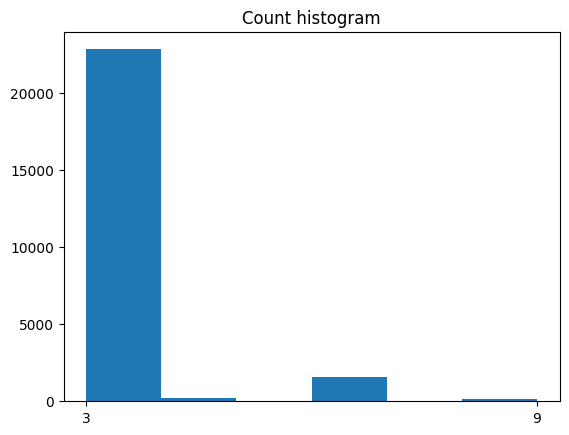

In [ ]:
plt.hist(twitts_data['count'], bins = 6)
plt.title('Count histogram')
plt.xticks([3,9], [3,9])
plt.show()

# Hate speech

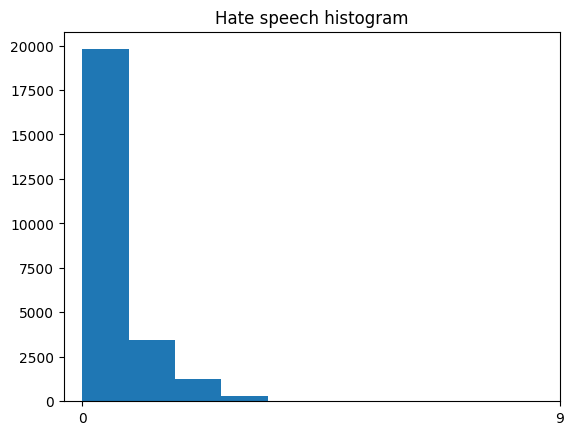

In [ ]:
plt.hist(twitts_data['hate_speech'], bins = 8)
plt.title('Hate speech histogram')
plt.xticks([0,9], [0,9])
plt.show()

# Offensive language

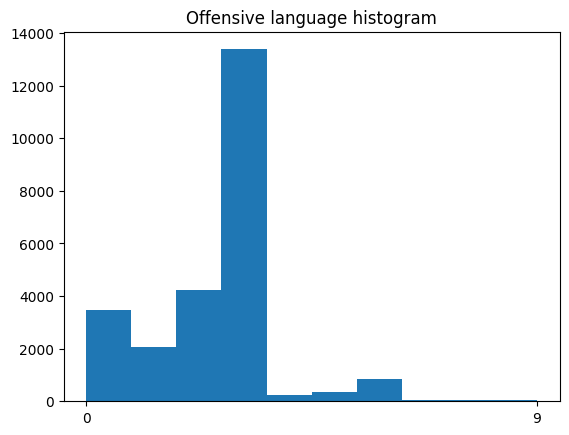

In [ ]:
plt.hist(twitts_data['offensive_language'], bins = 10)
plt.title('Offensive language histogram')
plt.xticks([0,9], [0,9])
plt.show()

# Neither

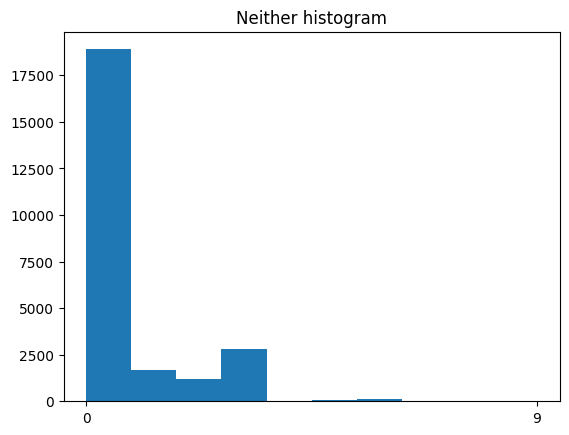

In [ ]:
plt.hist(twitts_data['neither'], bins = 10)
plt.title('Neither histogram')
plt.xticks([0,9], [0,9])
plt.show()

# Class

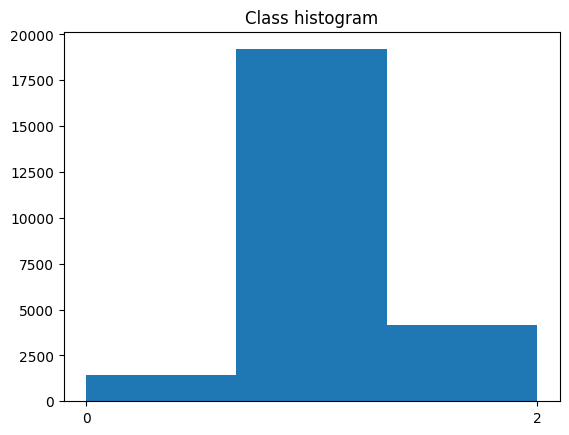

In [ ]:
plt.hist(twitts_data['class'], bins = 3)
plt.title('Class histogram')
plt.xticks([0,2], [0,2])
plt.show()

0 - hate speech
1 - offensive language
2 - netiher

# # Code preperation

In [ ]:
nltk.download('punkt_tab')
def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub(r"\@w+|\#",'',text)
    text = re.sub(r"[^\w\s]",'',text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    tweet_tokens = word_tokenize(text)
    filtered_tweets=[w for w in tweet_tokens if not w in stopword] #removing stopwords
    return " ".join(filtered_tweets)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:

twitts_data.tweet = twitts_data['tweet'].apply(clean)
text_data = twitts_data.drop_duplicates("tweet")

vect=TfidfVectorizer(ngram_range=(1,3)).fit(text_data['tweet'])


# Divide data for training and test

In [ ]:

X = text_data['tweet']
Y = text_data['class']
X = vect.transform(X) #Transformacja danych X

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15,
                                                    random_state=42)


In [ ]:
print("X_train count: ",X_train.size)
print("X_test count: ",X_test.size)

X_train count:  455109
X_test count:  79919


# Logistic regression

In [ ]:
logreg = LogisticRegression(max_iter = 300)
logreg.fit(X_train, Y_train)

logreg_predict = logreg.predict(X_test)

In [ ]:
print(classification_report(Y_test, logreg_predict))

              precision    recall  f1-score   support

           0       0.73      0.04      0.07       211
           1       0.85      0.99      0.91      2843
           2       0.88      0.51      0.65       622

    accuracy                           0.85      3676
   macro avg       0.82      0.51      0.54      3676
weighted avg       0.85      0.85      0.82      3676



# Making tokens for training and test data

In [ ]:
X = text_data['tweet']
Y = text_data['class']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15,
                                                    random_state=42)

x = X_train.values
y = Y_train.values

x_tokenizer = text.Tokenizer(20000)
x_tokenizer.fit_on_texts(list(x))

x_tokenized = x_tokenizer.texts_to_sequences(x)
x_train_val= sequence.pad_sequences(x_tokenized, maxlen=512)

x_test_tokenized = x_tokenizer.texts_to_sequences(X_test.values)
x_test = sequence.pad_sequences(x_test_tokenized,maxlen=512)

# Glove model loading

In [ ]:
embedding_dim =100
embeddings_index = dict()
f = open('/content/Children/Hatespeech/hatespeech_txt/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype = 'float32')
    embeddings_index[word]= coefs
f.close()
print(f'Glove model words count {len(embeddings_index)} word vectors')

Glove model words count 400000 word vectors


In [ ]:
embedding_matrix= np.zeros((20000,embedding_dim))
for word, index in x_tokenizer.word_index.items():
    if index>20000-1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index]= embedding_vector

In [ ]:
y_train_plus_val =  tf.keras.utils.to_categorical(y, num_classes=3)
y_test =  tf.keras.utils.to_categorical(Y_test.values, num_classes=3)
y_train_plus_val

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [ ]:
model = Sequential()
model.add(Embedding(20000,
                    embedding_dim,
                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                    trainable=False))

model.add(Dropout(0.2))

model.add(Conv1D(64,2,padding='valid',activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(64,2,padding='valid',activation='relu'))
model.add(MaxPooling1D())

model.add(Conv1D(32,2,padding='valid',activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(32,2,padding='valid',activation='relu'))
model.add(GlobalMaxPooling1D())

model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow.keras.backend as K

# Funkcie które pozwalały na trenowanie modelu od kątem optymalizacji wartości f1-score w przypadku modelu CNN
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives +
    K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#dodajemy nowe metryki, które polepszają f1-score
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy', f1_m, precision_m, recall_m])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=2,
    restore_best_weights=True
)

history = model.fit(x_train_val, y_train_plus_val, batch_size= 64, validation_split=0.2, epochs=10)



Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.7487 - f1_m: 0.6535 - loss: 0.7297 - precision_m: 0.7827 - recall_m: 0.5923 - val_accuracy: 0.8286 - val_f1_m: 0.8109 - val_loss: 0.4854 - val_precision_m: 0.8587 - val_recall_m: 0.7691
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8253 - f1_m: 0.8154 - loss: 0.4914 - precision_m: 0.8481 - recall_m: 0.7858 - val_accuracy: 0.8272 - val_f1_m: 0.8246 - val_loss: 0.4745 - val_precision_m: 0.8422 - val_recall_m: 0.8082
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8355 - f1_m: 0.8325 - loss: 0.4508 - precision_m: 0.8551 - recall_m: 0.8115 - val_accuracy: 0.8469 - val_f1_m: 0.8434 - val_loss: 0.4301 - val_precision_m: 0.8588 - val_recall_m: 0.8290
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8441 - f1_m: 0.8408 - loss: 0.4219 - precision_m: 0.8580 - recall_m: 0.8246 - val_accuracy: 0.8469 - val_f1_m: 0.8454 - val_loss: 0.4273 - val_precision_m: 0.8572 - val_recall_

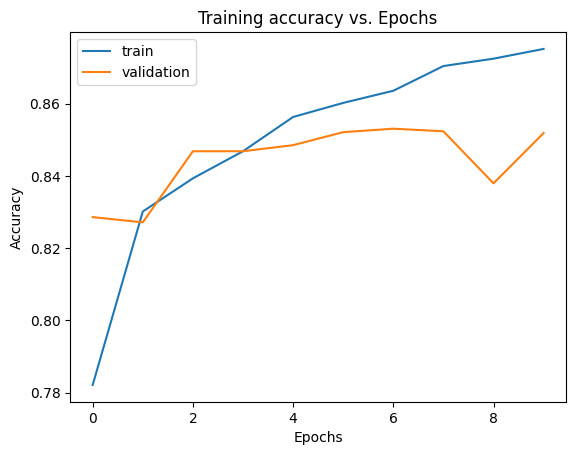

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs. Epochs')
plt.legend()
plt.show()

In [ ]:
model.evaluate(x_test,y_test, batch_size = 64)

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8510 - f1_m: 0.8504 - loss: 0.4258 - precision_m: 0.8655 - recall_m: 0.8359


[0.41668495535850525,
 0.8506528735160828,
 0.8500370383262634,
 0.8638077974319458,
 0.8368611335754395]

In [ ]:
y_pred = model.predict(x_test)
y_pred_raport = y_pred.argmax(axis = 1)
y_pred_raport

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
y_test_raport = y_test.argmax(axis = 1)
y_test_raport

array([1, 1, 2, ..., 1, 1, 1])

In [ ]:
print(classification_report(y_test_raport, y_pred_raport))

              precision    recall  f1-score   support

           0       0.46      0.03      0.05       211
           1       0.87      0.96      0.91      2843
           2       0.76      0.61      0.68       622

    accuracy                           0.85      3676
   macro avg       0.70      0.53      0.55      3676
weighted avg       0.83      0.85      0.82      3676



In [ ]:
accuracy = accuracy_score(y_test_raport, y_pred_raport)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.85


# **Training little transformer model using BERT pretrained encoder**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt

import nltk
from nltk.util import pr
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stopword = set(stopwords.words('english'))

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model

from transformers import BertTokenizer, TFBertModel

from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dropout

import seaborn as sns
import re
import string

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

In [ ]:
def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub(r"\@w+|\#",'',text)
    text = re.sub(r"[^\w\s]",'',text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    tweet_tokens = word_tokenize(text)
    filtered_tweets = [w for w in tweet_tokens if not w in stopword] #removing stopwords
    return " ".join(filtered_tweets)

# Pobranie i wyczyszczenie danych
tweets_data = pd.read_csv("/content/Children/Hatespeech/hatespeech_csv/labeled_data.csv")
tweets_data.tweet = tweets_data['tweet'].apply(clean)
tweets_data = tweets_data.drop_duplicates("tweet")

tweets = tweets_data['tweet']
classes = tweets_data['class']

class_encoder = LabelEncoder()
classes = class_encoder.fit_transform(classes)

tweets_train, tweets_test, classes_train, classes_test = train_test_split(tweets, classes, test_size=0.10, random_state=42)

tweets_train = tweets_train.values
tweets_test = tweets_test.values

classes_train = tf.cast(classes_train, tf.float32)
classes_test = tf.cast(classes_test, tf.float32)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

def encode_tweets(tweets):
    batch_size = 1000
    embeddings = []
    for i in range(0, len(tweets), batch_size):
        batch_texts = tweets[i:i+batch_size]
        tokenized_tweets = tokenizer(
            batch_texts.tolist(),
            max_length = 128,
            padding = True,
            truncation = True,
            return_tensors = 'tf'
        )
        inputs = {'input_ids': tokenized_tweets['input_ids'], 'attention_mask': tokenized_tweets['attention_mask']}
        outputs = bert_model(**inputs)
        batch_embeddings = outputs.last_hidden_state[:, 0, :]
        embeddings.append(batch_embeddings)
    return tf.concat(embeddings, axis = 0)

embeddings_train = encode_tweets(tweets_train)
embeddings_test = encode_tweets(tweets_test)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8082 - loss: 0.5220 - val_accuracy: 0.8397 - val_loss: 0.4198
Epoch 2/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8466 - loss: 0.4221 - val_accuracy: 0.8375 - val_loss: 0.4263
Epoch 3/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8538 - loss: 0.3963 - val_accuracy: 0.8506 - val_loss: 0.4085
Epoch 4/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8575 - loss: 0.3863 - val_accuracy: 0.8418 - val_loss: 0.4145
Epoch 5/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8607 - loss: 0.3703 - val_accuracy: 0.8422 - val_loss: 0.4104
Epoch 6/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8637 - loss: 0.3642 - val_accuracy: 0.8524 - val_loss: 0.3957
Epoch 7/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8667 - loss: 0.3545 - val_accuracy: 0.8522 - val_loss: 0.4045
Epoch 8/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8683 - loss: 0.3407 - val_accuracy: 0

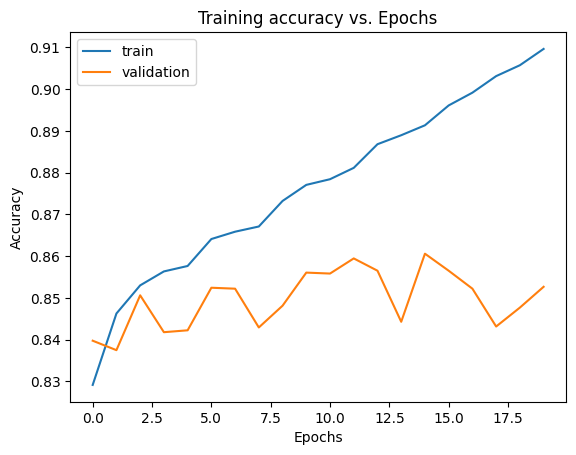

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
              precision    recall  f1-score   support

         0.0       0.48      0.09      0.15       144
         1.0       0.89      0.95      0.92      1913
         2.0       0.74      0.71      0.72       394

    accuracy                           0.86      2451
   macro avg       0.70      0.58      0.60      2451
weighted avg       0.84      0.86      0.84      2451



In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives +
    K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

model = Sequential()
model.add(Input(shape=(768,)))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation = 'softmax'))

model.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(embeddings_train, classes_train, epochs = 20, batch_size = 64, validation_split = 0.2,
                   callbacks = [early_stopping])

plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs. Epochs')
plt.legend()
plt.show()

predictions = model.predict(embeddings_test)
predictions = predictions.argmax(axis = 1)

print(classification_report(classes_test, predictions))



In [ ]:

# Define a mapping from class numbers to labels
class_mapping = {
    0: "Hate speech",
    1: "Offensive language",
    2: "neither"
}

# Function to preprocess and predict a single input
def predict_single_input(text):
    # Step 1: Clean the input text
    cleaned_text = clean(text)

    # Step 2: Encode the cleaned text with BERT tokenizer
    tokenized_tweet = tokenizer(
        [cleaned_text],
        max_length=128,
        padding=True,
        truncation=True,
        return_tensors='tf'
    )

    # Prepare inputs for the BERT model
    inputs = {
        'input_ids': tokenized_tweet['input_ids'],
        'attention_mask': tokenized_tweet['attention_mask']
    }

    # Step 3: Get the BERT embeddings
    bert_output = bert_model(**inputs)
    embedding = bert_output.last_hidden_state[:, 0, :]

    # Step 4: Predict using the trained model
    prediction = model.predict(embedding)
    predicted_class = prediction.argmax(axis=1)[0]

    # Step 5: Decode the predicted class to human-readable label
    predicted_label = class_mapping[predicted_class]

    return predicted_label

# Example usage
text_input = ""
predicted_label = predict_single_input(text_input)
print(f"Predicted Label: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted Label: Hate speech


In [ ]:
!pip install transformers tensorflow


In [ ]:
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf

# Define a mapping from class numbers to labels
class_mapping = {
    0: "Hate speech",
    1: "Offensive language",
    2: "Neither"
}

# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

# Assume the classification model is already trained and available in memory
# Example: This model should be trained in the same script or session
# model = ... (Your trained model here)

# Define the clean function (example)
def clean(text):
    # Add your cleaning logic (e.g., removing special characters, lowercasing, etc.)
    text = text.lower()
    text = ''.join([c for c in text if c.isalnum() or c.isspace()])
    return text

# Function to preprocess and predict a single input
def predict_single_input(text):
    # Step 1: Clean the input text
    cleaned_text = clean(text)

    # Step 2: Encode the cleaned text with BERT tokenizer
    tokenized_tweet = tokenizer(
        [cleaned_text],
        max_length=128,
        padding=True,
        truncation=True,
        return_tensors='tf'
    )

    # Prepare inputs for the BERT model
    inputs = {
        'input_ids': tokenized_tweet['input_ids'],
        'attention_mask': tokenized_tweet['attention_mask']
    }

    # Step 3: Get the BERT embeddings
    bert_output = bert_model(**inputs)
    embedding = bert_output.last_hidden_state[:, 0, :]

    # Step 4: Predict using the trained model (already in memory)
    prediction = model.predict(embedding)
    predicted_class = prediction.argmax(axis=1)[0]

    # Step 5: Decode the predicted class to human-readable label
    predicted_label = class_mapping[predicted_class]

    return predicted_label

# Example usage: Input a sentence for prediction
text_input = input("Enter a sentence to classify: ")
predicted_label = predict_single_input(text_input)
print(f"Predicted Label: {predicted_label}")


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Enter a sentence to classify: As a woman you shouldn't complain about cleaning up your house
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted Label: Offensive language
